# CatGAN

This is a generative adversarial network to produce cat images. It was trained on the cat dataset with 64x64 images from Kaggle. Here, we generate the images using two architecutres - the DCGAN and the vanilla GAN proposed by Goodfellow. Credits to https://github.com/soumith/ganhacks this article for providing insights into training effectively.

## Setup

In [21]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import CatDataset as cdset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        img = img.reshape(3, 64, 64)
        img = np.moveaxis(img, 0, -1)
        plt.imshow(img)
    return 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

We will use the Kaggle dataset of cats (64x64) which can be downloaded from the `data.sh` script.

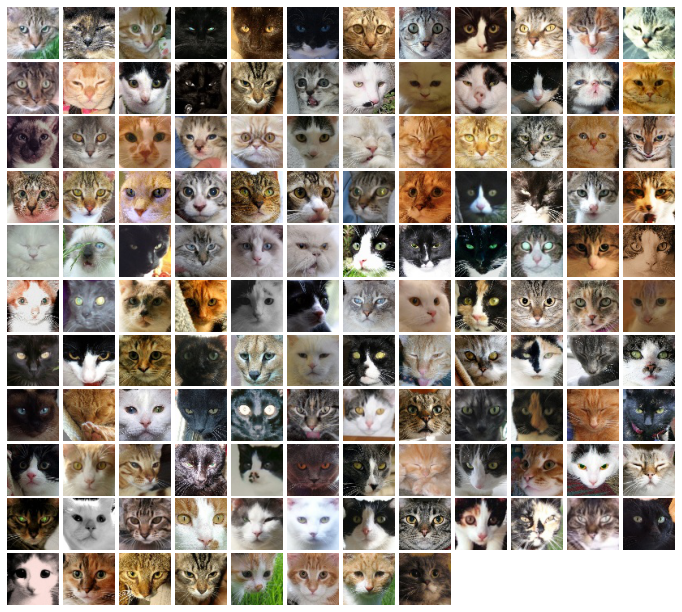

In [2]:
NUM_TRAIN = 12800
NUM_VAL = 3000

NOISE_DIM = 96
batch_size = 128

cat_train = cdset.CatDataset('./cats')
loader_train = DataLoader(cat_train, batch_size=batch_size,
                          shuffle=True)

cat_val = cdset.CatDataset('./cats')
loader_val = DataLoader(cat_val, batch_size=batch_size,
                        shuffle=True)

imgs = loader_train.__iter__().next().view(batch_size, 3, 4096).numpy().squeeze()
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Implement `sample_noise` in `cs231n/gan_pytorch.py`.

Hint: use `torch.rand`.

Make sure noise is the correct shape and type:

In [3]:
from helpers.gan import sample_noise

# def test_sample_noise(): 
#     batch_size = 3
#     dim = 64*64
#     torch.manual_seed(231)
#     z = sample_noise(batch_size, dim)
#     np_z = z.cpu().numpy()
#     assert np_z.shape == (batch_size, dim)
#     assert torch.is_tensor(z)
#     assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
#     assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
#     print('All tests passed!')
    
# test_sample_noise()

In [4]:
from helpers.gan import Flatten, Unflatten, initialize_weights

## CPU / GPU

In [5]:
# dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

In [6]:
from helpers.gan import discriminator_loss, generator_loss
from helpers.gan import get_optimizer, run_a_gan

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks 

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use Unflatten!)
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Implement `build_dc_classifier` in `cs231n/gan_pytorch.py`

In [7]:
from helpers.gan import build_dc_classifier

# data = next(enumerate(loader_train))[-1].type(dtype)
# b = build_dc_classifier(batch_size).type(dtype)
# out = b(data)
# print(out.size())

#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode. 
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector

Implement `build_dc_generator` in `cs231n/gan_pytorch.py`

In [8]:
from helpers.gan import build_dc_generator

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM, 1, 1).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 12288])

Iter: 0, D: 1.487, G:8.911


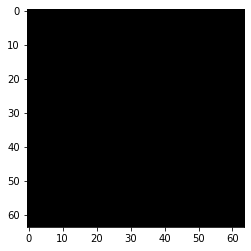

Iter: 50, D: 0.3514, G:6.516


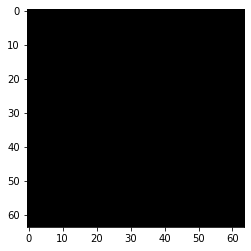

Iter: 100, D: 0.3333, G:7.083


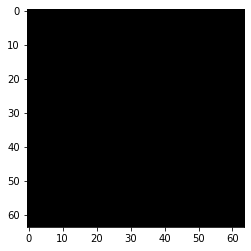

Iter: 150, D: 0.3385, G:8.132


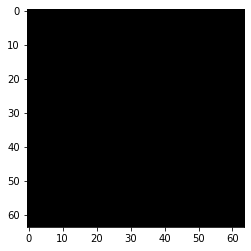

Iter: 200, D: 0.3286, G:8.615


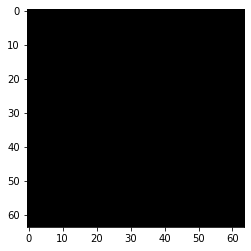

Iter: 250, D: 0.3281, G:7.912


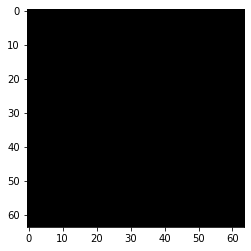

Iter: 300, D: 0.3264, G:9.06


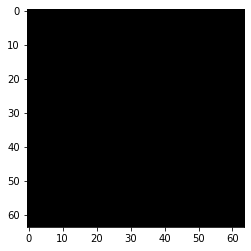

Iter: 350, D: 0.3291, G:8.514


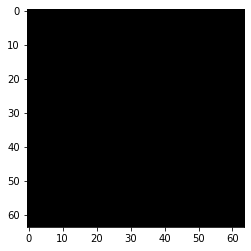

Iter: 400, D: 0.3557, G:7.432


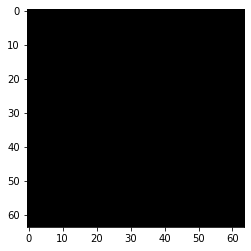

Iter: 450, D: 0.3311, G:8.596


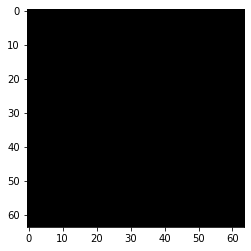

Iter: 500, D: 0.3312, G:9.064


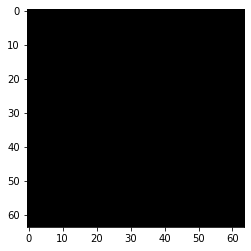

Iter: 550, D: 0.3267, G:8.983


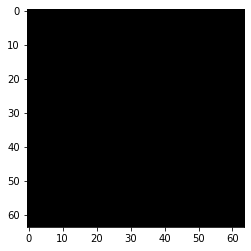

Iter: 600, D: 0.3303, G:8.726


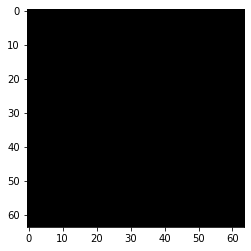

Iter: 650, D: 0.3294, G:8.781


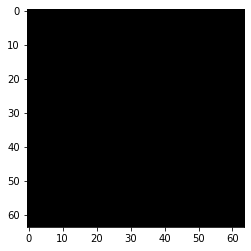

Iter: 700, D: 0.3262, G:9.35


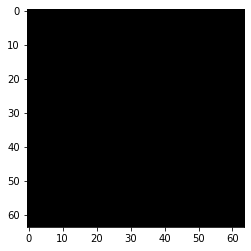

Iter: 750, D: 0.3356, G:8.364


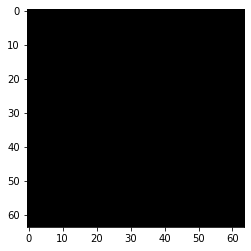

Iter: 800, D: 0.3275, G:10.07


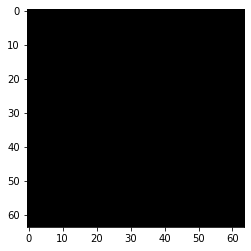

Iter: 850, D: 0.5403, G:4.411


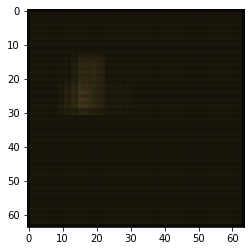

Iter: 900, D: 0.3476, G:5.678


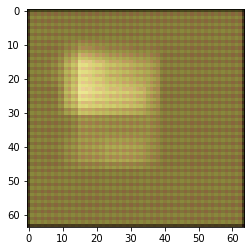

Iter: 950, D: 0.3352, G:7.726


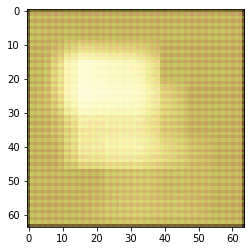

Iter: 1000, D: 0.3504, G:6.65


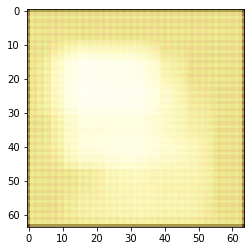

Iter: 1050, D: 0.329, G:7.535


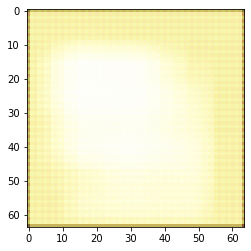

Iter: 1100, D: 0.3283, G:8.012


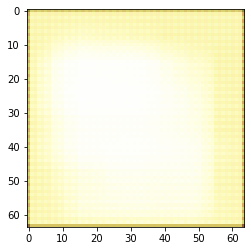

Iter: 1150, D: 0.3274, G:8.295


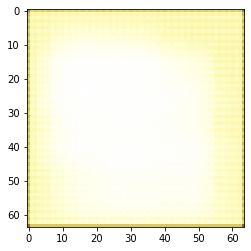

Iter: 1200, D: 0.3267, G:8.247


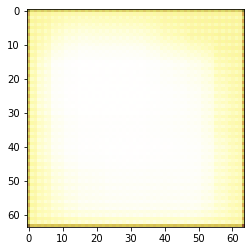

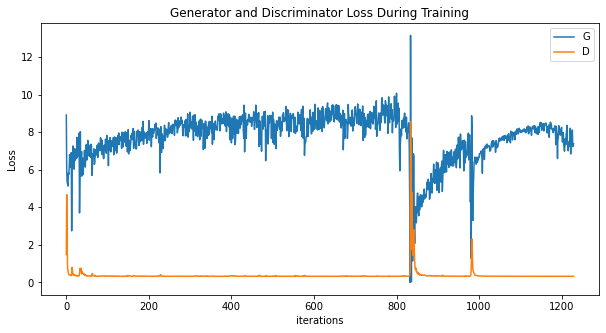

In [28]:
D_DC = build_dc_classifier(batch_size).type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator(NOISE_DIM).type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC, 0.0005)
G_DC_solver = get_optimizer(G_DC, 0.0002)

images, G_losses, D_losses = run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, loader_train, noise_size=NOISE_DIM, num_epochs=10)

torch.save(D_DC_solver, "./d_trained.pth")
torch.save(G_DC_solver, "./g_trained.pth")

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Run the cell below to show generated images.

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

In [ ]:
print("DCGAN Fianl image:")
show_images(images[-1])
plt.show()